## UpSet plot.

In [7]:
# Autoreload 
%load_ext autoreload
%autoreload 2

from pathlib import Path 
import pandas as pd 
import numpy as np
import os 
import re 
import gzip 
import shutil
import Bio.PDB.MMCIF2Dict
from typing import Union, List, Tuple, Dict, Optional
from pathlib import Path

pd.options.mode.chained_assignment = None  # default='warn'

from phosphosite import DATA_DIR
from phosphosite.utils import aa1to3, aa3to1


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Parameters.

In [18]:
load_csv = False

In [19]:
to_process = "all"
residue_type = "STY"
radius = 6.0
residue_adjacent = 2
next_nearest = 3
ref_atom = "ca"

out_filename = f"{to_process}-{residue_type}-{int(radius)}A{residue_adjacent}R{next_nearest}N-{ref_atom}.csv"
outfile = DATA_DIR / "motif" / out_filename

if load_csv: 
    # Load background_df 
    background_df = pd.read_csv(outfile, sep="\t")
    # Save as hdf5
    background_df.to_hdf(outfile.with_suffix(".h5"), key="df", mode="w")

In [25]:
background_df = pd.read_hdf(outfile.with_suffix(".h5"), key="df")
len(background_df["protein_id"].unique())

17236

In [26]:
background_df["site_res"] = background_df.apply(
    lambda row: row["site"][0], 
    axis=1,
)
for i in range(1, next_nearest + 1):
    nearest_node = background_df[~background_df[f"{str(i)}_res"].isna()]
    percentage = len(nearest_node) / len(background_df) * 100
    print(f"{percentage:.1f}% of motifs have a {i}-nearest residue. ({len(nearest_node)} / {len(background_df)})")

60.0% of motifs have a 1-nearest residue. (975792 / 1626747)
45.1% of motifs have a 2-nearest residue. (733780 / 1626747)
24.3% of motifs have a 3-nearest residue. (394733 / 1626747)


In [27]:
background_df.columns

Index(['phosphosite', 'site_qual', 'protein_id', '-2', '-1', 'site', '+1',
       '+2', '1_res', '1_euc_dist', '1_seq_dist', '2_res', '2_euc_dist',
       '2_seq_dist', '3_res', '3_euc_dist', '3_seq_dist', 'site_res'],
      dtype='object')

In [30]:
dict_list = []
for residue in "STY":

    dict_list.append(dict(
        residue=residue,
        val=1,
    ))
    

df = pd.DataFrame(dict_list)
df

,residue,val
0,S,1
1,T,1
2,Y,1


In [5]:
import numpy as np

In [14]:
background_df

,phosphosite,site_qual,protein_id,-2,-1,site,+1,+2,1_res,1_euc_dist,1_seq_dist,2_res,2_euc_dist,2_seq_dist,3_res,3_euc_dist,3_seq_dist,1,2,site_res
0,False,93.22,A0A075B759,V2,N3,S4,V5,V6,L24,5.713606,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S
1,False,98.17,A0A075B759,R19,I20,S21,I22,K23,F7,4.469890,-14.0,E134,5.271362,113.0,K133,5.408332,112.0,NaN,NaN,S
2,True,98.29,A0A075B759,A38,L39,S40,T41,G42,G162,4.818600,122.0,R37,5.002838,-3.0,C161,5.410340,121.0,NaN,NaN,S
3,False,97.89,A0A075B759,K49,G50,S51,C52,F53,F67,4.940918,16.0,Y48,5.325484,-3.0,I158,5.665806,107.0,NaN,NaN,S
4,False,97.64,A0A075B759,D75,K76,S77,I78,Y79,G109,4.512408,32.0,G80,5.279793,3.0,S110,5.320260,33.0,NaN,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10400,False,96.46,A4D126,D269,L270,Y271,A272,A273,E274,5.116022,3.0,R268,5.218039,-3.0,NaN,NaN,NaN,NaN,NaN,Y
10401,False,95.37,A4D126,Q334,C335,Y336,N337,F338,V369,4.893747,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
10402,False,95.59,A4D126,I365,L366,Y367,P368,V369,C364,5.485461,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
10403,False,98.46,A4D126,L407,L408,Y409,G410,L411,V372,4.828831,-37.0,I445,5.214119,36.0,G446,5.247621,37.0,NaN,NaN,Y


#### Upset plot of combinations.

In [35]:
phosphosites = background_df[background_df["phosphosite"] == True]
not_phosphosites = background_df[background_df["phosphosite"] == False]

res = "S"

df = phosphosites[phosphosites["site_res"] == res]


128451

In [36]:
# Create upset plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=("Phosphosites", "Non-phosphosites"),
    shared_yaxes=True,
)


In [37]:
fig.add_trace(
    go.Bar(
        x=df["protein_id"].value_counts().index,
        y=df["protein_id"].value_counts().values,
        name="Phosphosites",
    ),
    row=1,
    col=1,
)

df = not_phosphosites[not_phosphosites["site_res"] == res]

fig.add_trace(
    go.Bar(
        x=df["protein_id"].value_counts().index,
        y=df["protein_id"].value_counts().values,
        name="Non-phosphosites",
    ),
    row=1,
    col=2,
)

fig.update_layout(
    title_text=f"Phosphosites vs non-phosphosites for {res} residues",
    height=600,
    width=1200,
    showlegend=False,
)

fig.show()


#### MultiIndex for each combination of AA

In [49]:
from phosphosite.utils import standard_residues
pd.MultiIndex.from_product(
    [list(standard_residues) for i in range(3)], 
    names=["res1", "res2", "res3"]
)

MultiIndex([('A', 'A', 'A'),
            ('A', 'A', 'C'),
            ('A', 'A', 'D'),
            ('A', 'A', 'E'),
            ('A', 'A', 'F'),
            ('A', 'A', 'G'),
            ('A', 'A', 'H'),
            ('A', 'A', 'I'),
            ('A', 'A', 'K'),
            ('A', 'A', 'L'),
            ...
            ('Y', 'Y', 'M'),
            ('Y', 'Y', 'N'),
            ('Y', 'Y', 'P'),
            ('Y', 'Y', 'Q'),
            ('Y', 'Y', 'R'),
            ('Y', 'Y', 'S'),
            ('Y', 'Y', 'T'),
            ('Y', 'Y', 'V'),
            ('Y', 'Y', 'W'),
            ('Y', 'Y', 'Y')],
           names=['res1', 'res2', 'res3'], length=8000)

In [149]:
# Get pd.Series of counts for each combination of residues in background_df
psites = phosphosites
for i in [1, 2, 3]:
    psites[f"res{i}"] = psites[f"{i}_res"].str[0]
psite_counts = psites.groupby(["site_res", "res1", "res2", "res3"]).size()
print(psite_counts)
#psite_counts["S", "F", "E"]
# Number of rows in psites with res1, res2, or res3 is nan 
len(psites[psites[["res1", "res2", "res3"]].isna().any(axis=1)])

site_res  res1  res2  res3
S         A     A     A       13
                      C        3
                      D        1
                      E        7
                      F        2
                              ..
Y         Y     Y     N        8
                      Q        4
                      S        2
                      T        4
                      Y        1
Length: 13938, dtype: int64


184901

In [150]:
# numpy where version
df = psites[["site_res", "res1", "res2", "res3"]]
a = df[["res1", "res2", "res3"]].values
for res in standard_residues:
    df[res] = np.where(
        # Return true if res is in any of res1, res2, or res3 using np.isin 
        np.isin(a, res).any(axis=1),
        1,
        0,
    )
df


,site_res,res1,res2,res3,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
9,S,D,K,M,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
11,S,F,E,NaN,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
42,Y,Y,V,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
43,Y,Y,I,V,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
44,Y,Y,P,F,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626674,Y,D,NaN,NaN,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1626704,Y,Y,S,NaN,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1626712,Y,V,I,N,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1626718,S,F,L,NaN,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


184901

In [143]:
# Count each unique combination of residues 
combo_counts = df.groupby(list(standard_residues)).size()

# Add 'site_res' column to combo_counts
combo_counts = combo_counts.to_frame().reset_index()
combo_counts["site_res"] = 

# Remove all zero row combinations
# i.e. index where all standard_residues are 0
combo_counts = combo_counts[combo_counts.index.to_frame().any(axis=1)]

# Remove single residue combinations
# i.e. index where only one standard_residue is 1
#combo_counts = combo_counts[combo_counts.index.to_frame().sum(axis=1) > 1]

# Sort in descending order of count 
combo_counts = combo_counts.sort_values(ascending=False)

# Remove all rows where the count is < 10
combo_counts = combo_counts[combo_counts > 200]
len(combo_counts)


94

## Serine

In [156]:
# Create dataframe for SERINE with counts for each combination of residues
processed_df = background_df
for i in [1, 2, 3]:
    processed_df[f"res{i}"] = processed_df[f"{i}_res"].str[0]

processed_df = processed_df[["phosphosite", "site_res", "res1", "res2", "res3"]]

# Create column for each residue indicating set membership
a = processed_df[["res1", "res2", "res3"]].values
for res in standard_residues:
    processed_df[res] = np.where(
        # Return true if res is in any of res1, res2, or res3 using np.isin 
        np.isin(a, res).any(axis=1),
        1,
        0,
    )
processed_df

,phosphosite,site_res,res1,res2,res3,A,C,D,E,F,...,M,N,P,Q,R,S,T,V,W,Y
0,False,S,L,V,V,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,False,S,H,M,G,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,False,S,NaN,NaN,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,S,F,T,NaN,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,False,S,NaN,NaN,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626742,False,Y,I,K,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1626743,False,Y,D,N,L,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1626744,False,Y,D,NaN,NaN,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1626745,False,Y,NaN,NaN,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
# Turn all residue columns into multiindex
processed_df = processed_df.set_index(list(standard_residues))
processed_df

phosphosite site_res res1 res2 res3
A C D E F G H I K L M N P Q R S T V W Y                                     
0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0        False        S    L    V    V
          1 1 0 0 0 1 0 0 0 0 0 0 0 0 0        False        S    H    M    G
          0 0 0 0 0 0 0 0 0 0 0 0 0 0 0        False        S  NaN  NaN  NaN
        1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0        False        S    F    T  NaN
        0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0        False        S  NaN  NaN  NaN
...                                              ...      ...  ...  ...  ...
              1 1 0 0 0 0 0 0 0 0 0 0 0        False        Y    I    K  NaN
    1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0        False        Y    D    N    L
                  0 0 0 0 0 0 0 0 0 0 0        False        Y    D  NaN  NaN
    0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0        False        Y  NaN  NaN  NaN
      1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0        False        Y    E    V    Q

[1626747 rows x 5 columns]

In [158]:
# Drop columns "res1", "res2", "res3"
processed_df = processed_df.drop(columns=["res1", "res2", "res3"])
processed_df

phosphosite site_res
A C D E F G H I K L M N P Q R S T V W Y                      
0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0        False        S
          1 1 0 0 0 1 0 0 0 0 0 0 0 0 0        False        S
          0 0 0 0 0 0 0 0 0 0 0 0 0 0 0        False        S
        1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0        False        S
        0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0        False        S
...                                              ...      ...
              1 1 0 0 0 0 0 0 0 0 0 0 0        False        Y
    1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0        False        Y
                  0 0 0 0 0 0 0 0 0 0 0        False        Y
    0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0        False        Y
      1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0        False        Y

[1626747 rows x 2 columns]

#### By phosphosite/notphosphosite

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>,
 'extra1': <Axes: >}

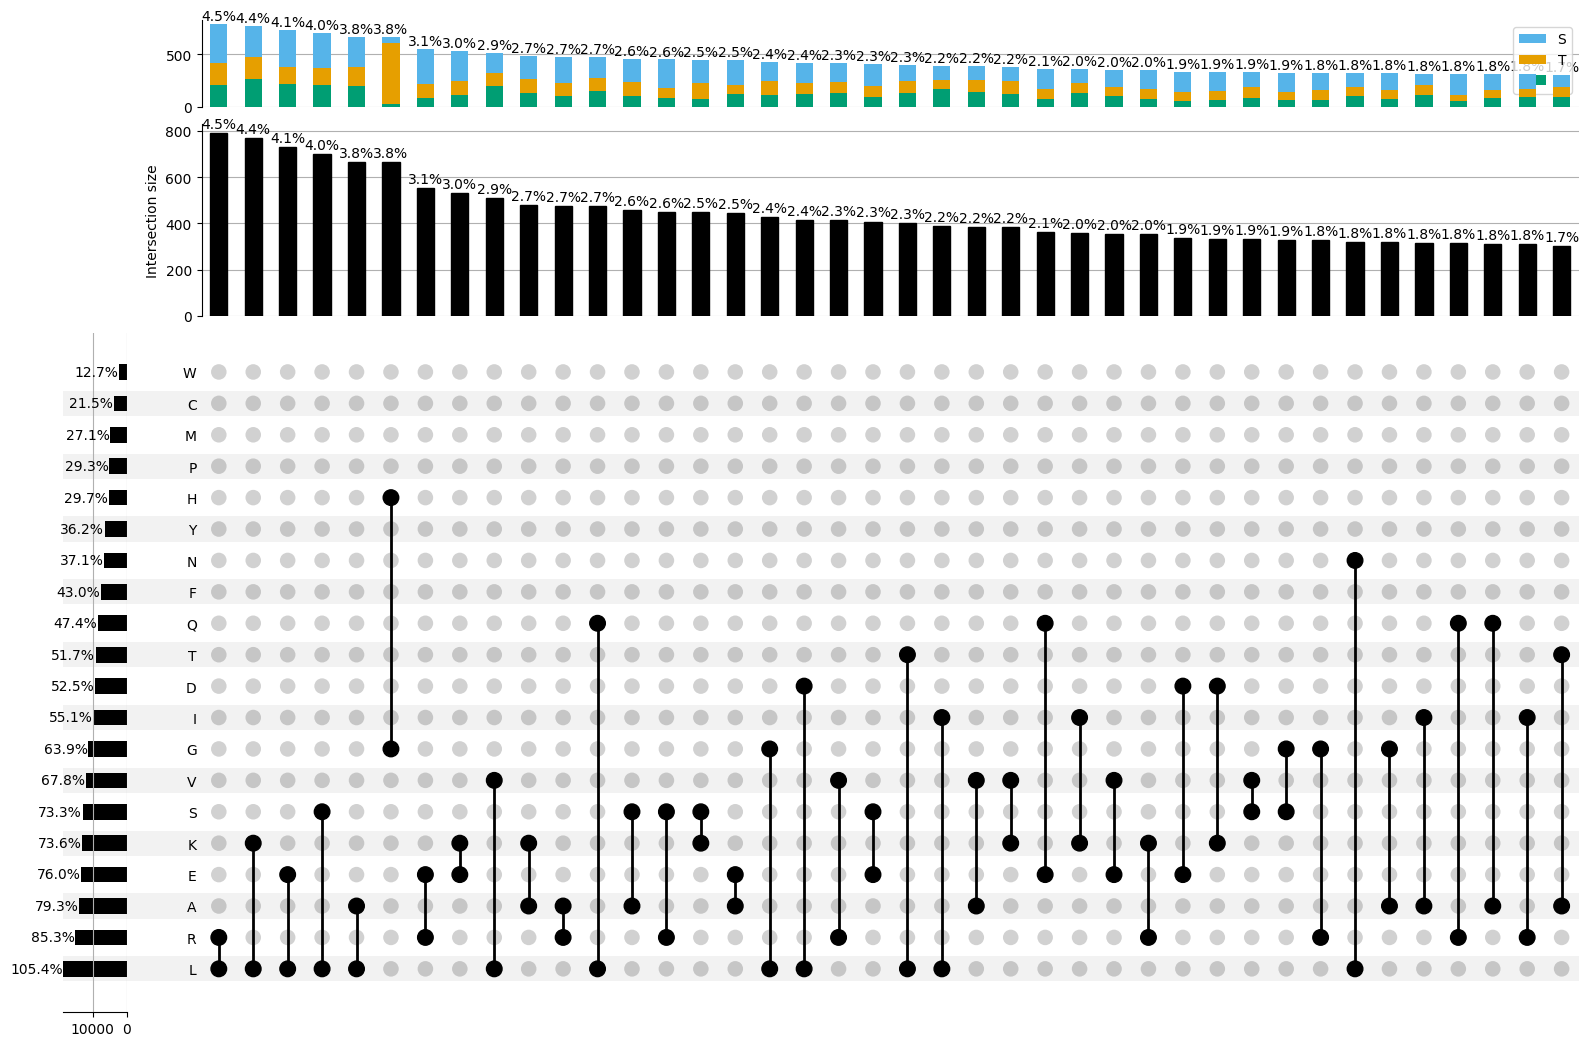

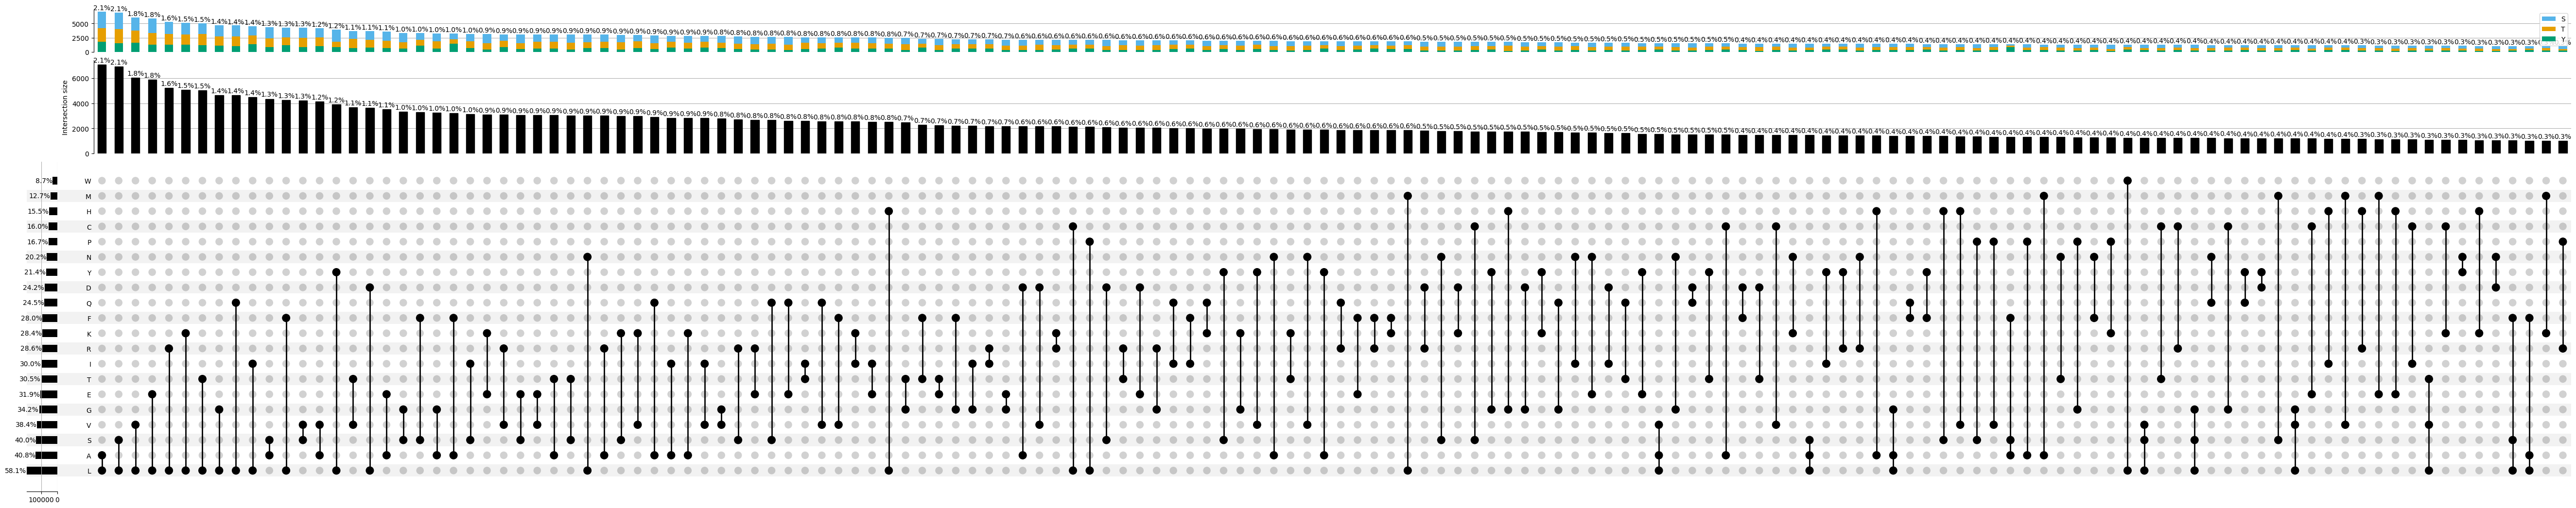

In [178]:
from upsetplot import plot, UpSet

min_subset_size = 300
min_degree = 2 # 2
# Create upset plot
upset = UpSet(
    processed_df[processed_df["phosphosite"] == True],
    sort_by="cardinality",
    #show_counts=True,
    show_percentages=True,
    orientation="horizontal",
    min_subset_size=min_subset_size,
    min_degree=min_degree,
)
upset.add_stacked_bars(
    by="site_res",
    colors=["#56B4E9", "#E69F00", "#009E73"],
)
upset.plot()

min_subset_size = 1000
min_degree = 2 # 2
# Create upset plot
upset = UpSet(
    processed_df[processed_df["phosphosite"] == False],
    sort_by="cardinality",
    #show_counts=True,
    show_percentages=True,
    orientation="horizontal",
    min_subset_size=min_subset_size,
    min_degree=min_degree,
)
upset.add_stacked_bars(
    by="site_res",
    colors=["#56B4E9", "#E69F00", "#009E73"],
)
upset.plot()

#### By residue

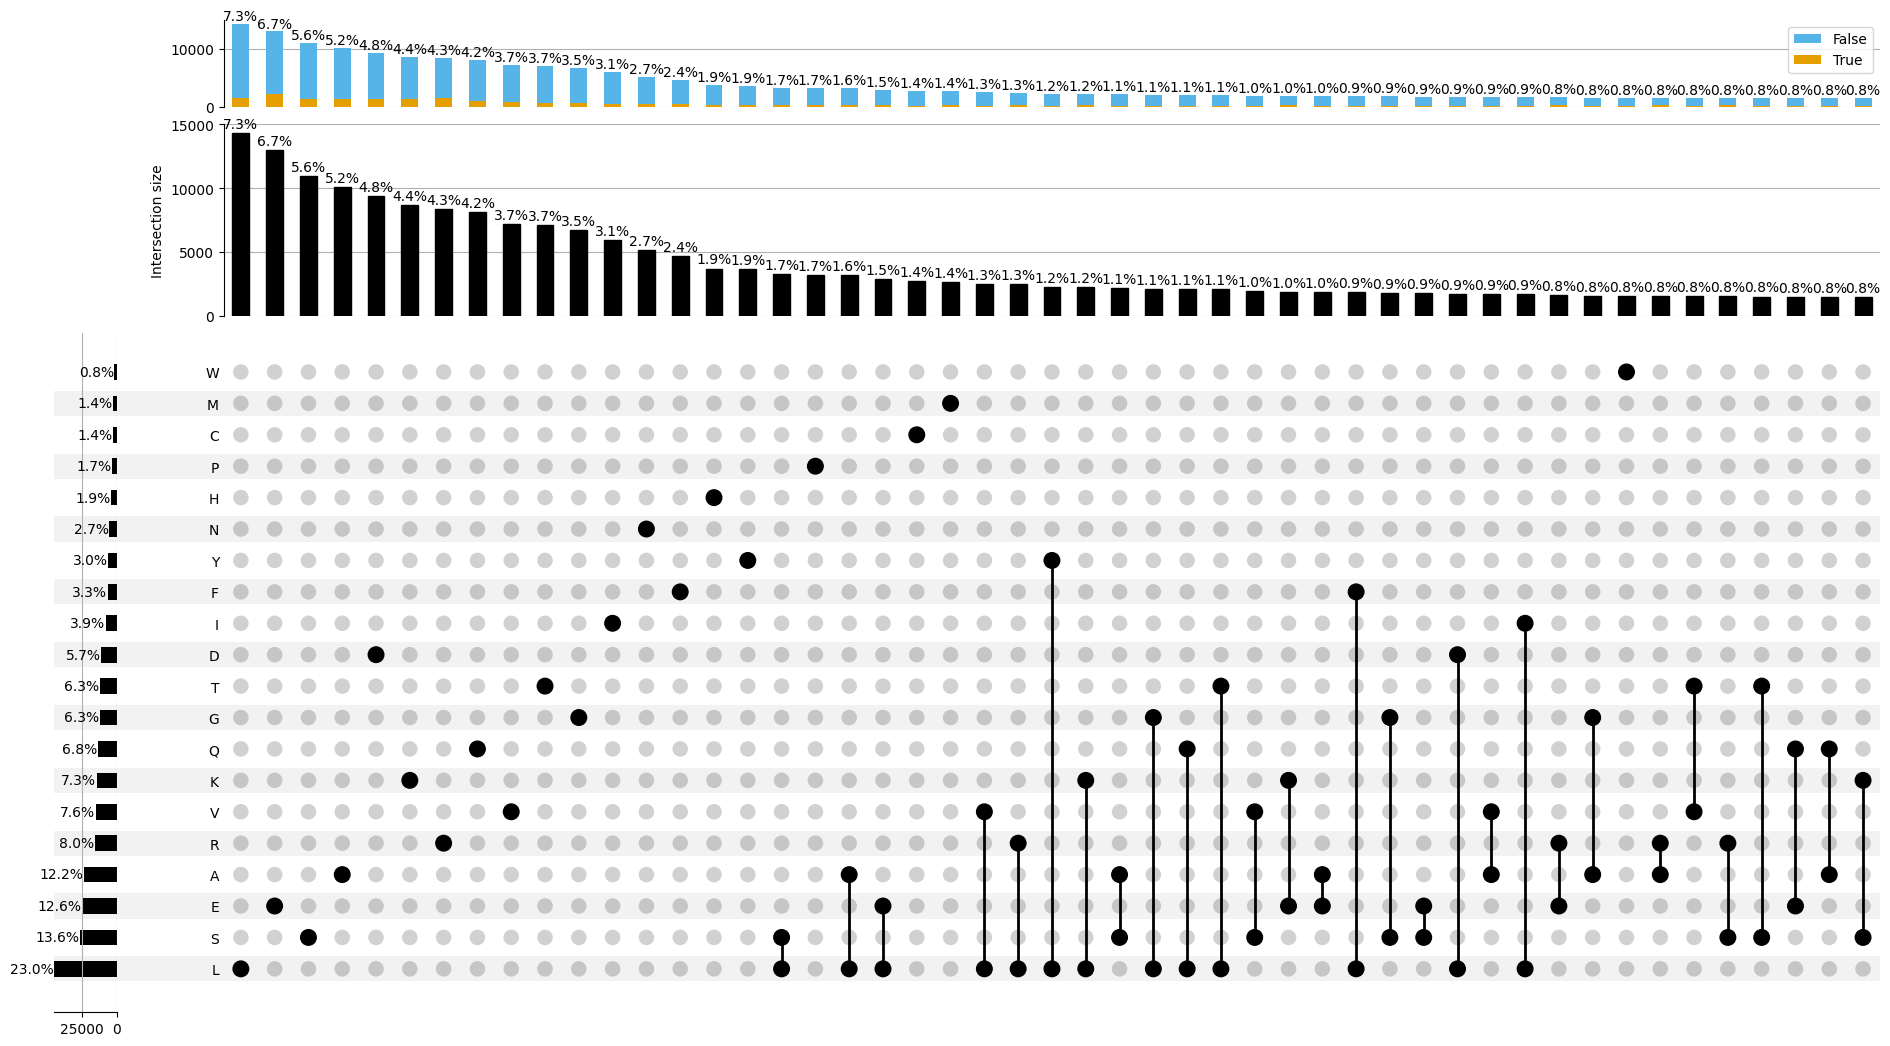

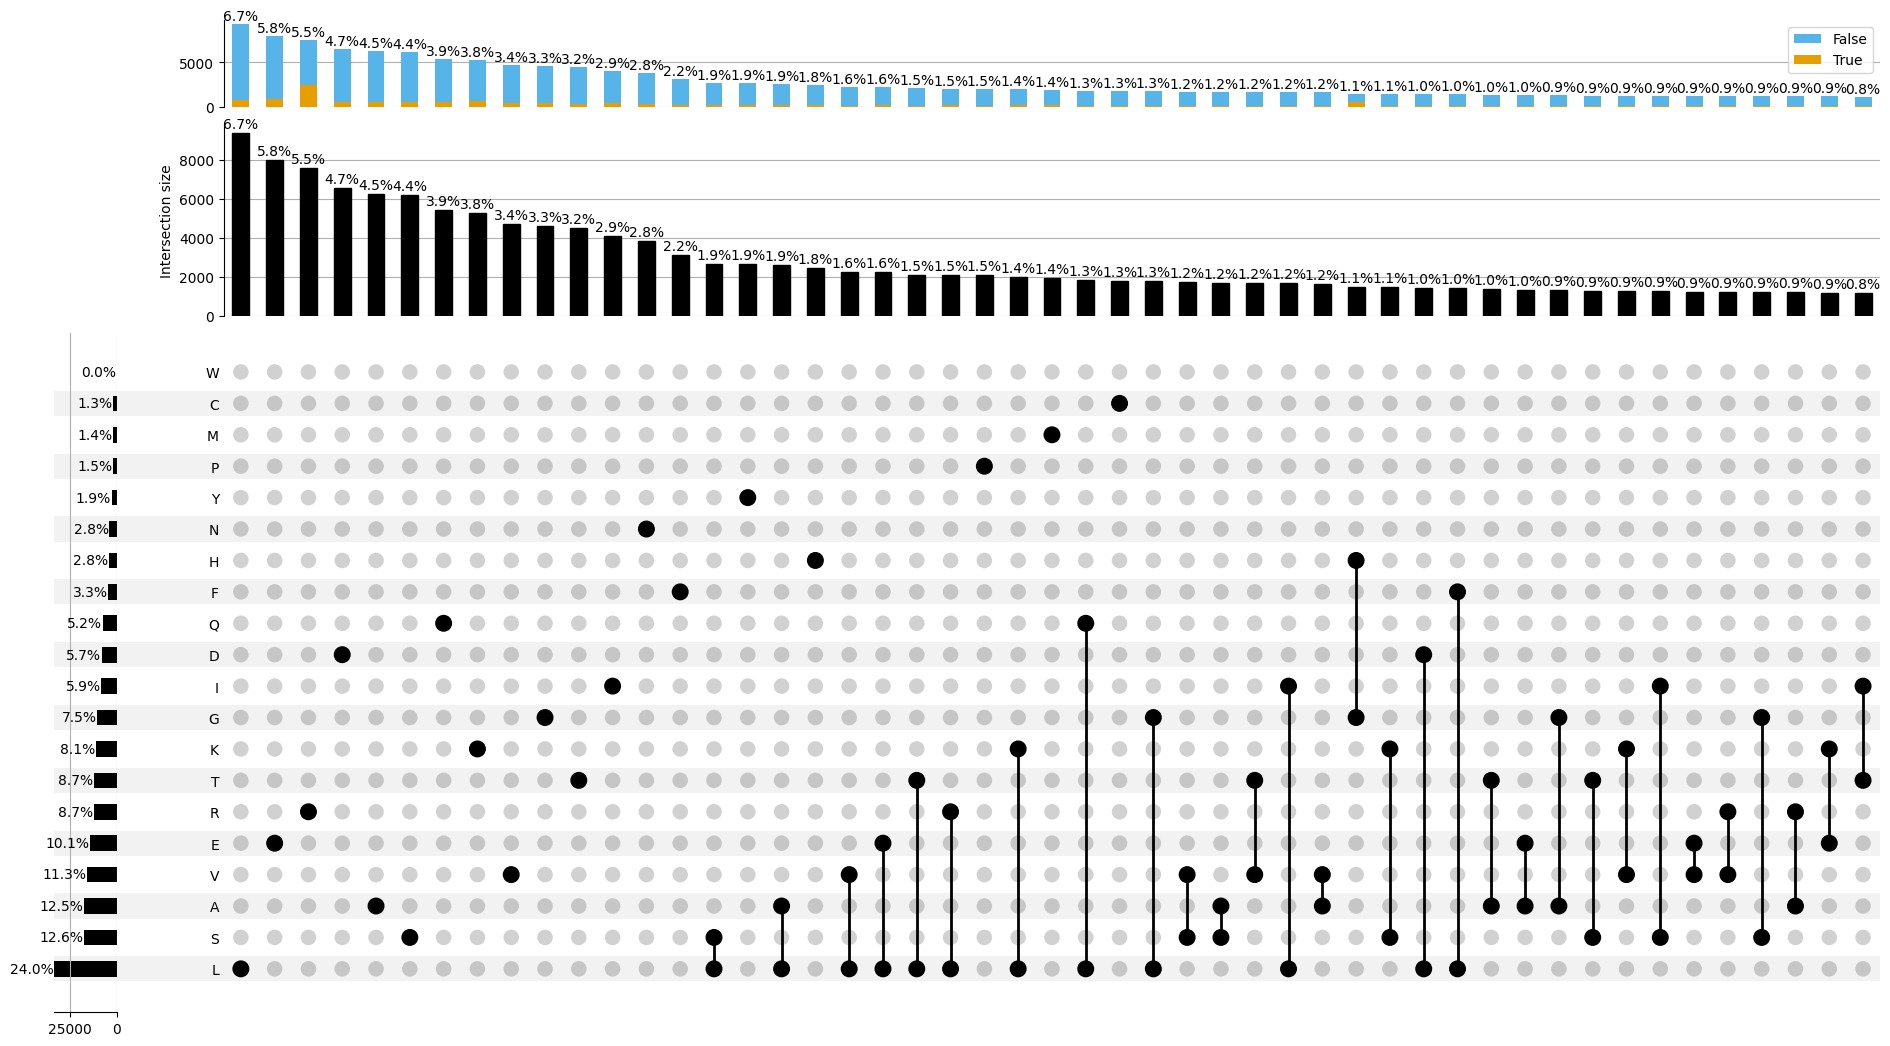

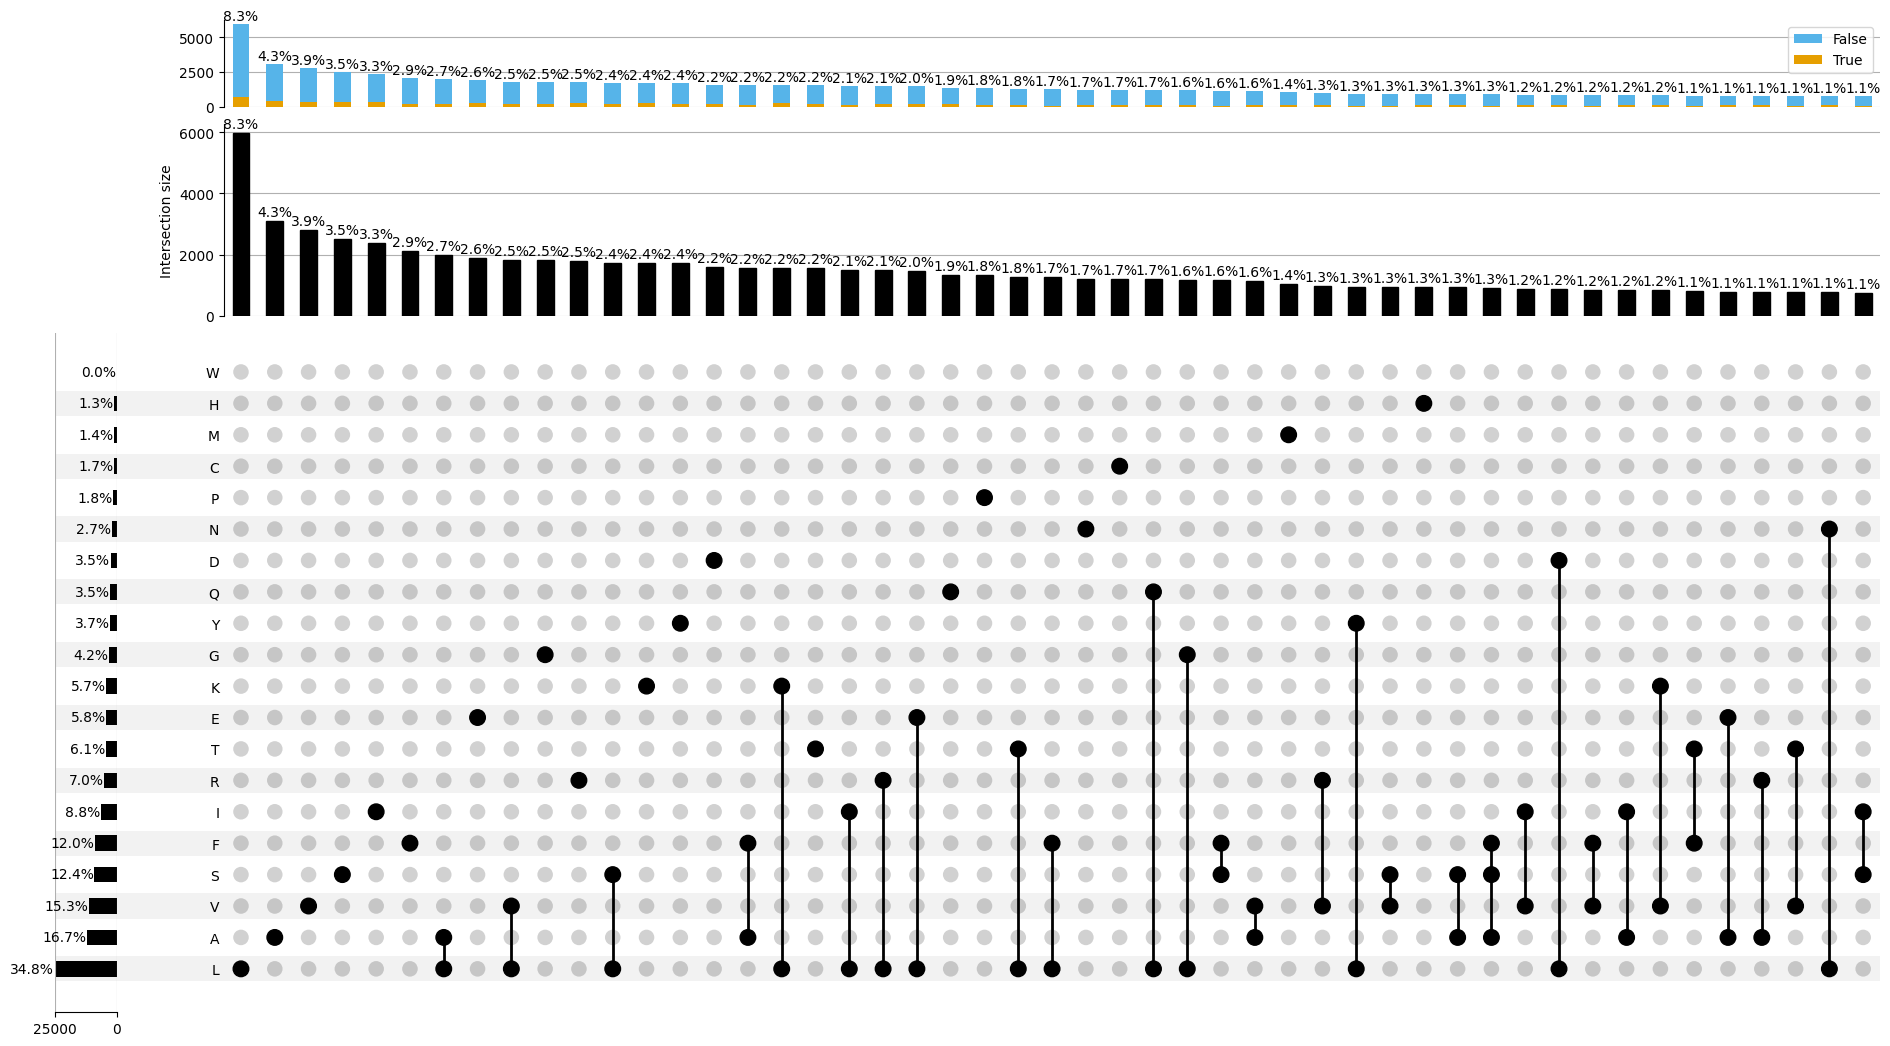

In [184]:
from upsetplot import plot, UpSet

max_number_subsets = 50
min_subset_size = 0
min_degree = 1 # 2
max_degree = 2
# Create upset plot
for res in "STY":
    df = processed_df[processed_df["site_res"] == res]
    # Count occurrences of each combination of residues. 
    # i.e. generate count df 
    combo_counts = df.groupby(list(standard_residues)).size()

    # Sort by count
    combo_counts = combo_counts.sort_values(ascending=False)
    # Top 50 
    combo_counts = combo_counts[:max_number_subsets]


    # Filter df to only include rows whose index is in combo_counts
    df = df[df.index.isin(combo_counts.index)] 


    upset = UpSet(
        df,
        sort_by="cardinality",
        #show_counts=True,
        show_percentages=True,
        orientation="horizontal",
        min_subset_size=min_subset_size,
        min_degree=min_degree,
    )
    upset.add_stacked_bars(
        by="phosphosite",
        title="Distribution of phosphosites",
        colors=["#56B4E9", "#E69F00"], #"#009E73"],
    )
    upset.plot()